In [132]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

In [167]:
DATA_SRC = './styletopicmodeling/data/enron/users_data_50_unique_clean_min_10_fixed_sender.tsv'

BATCH_SIZE = 512
NUM_WORKERS = 8

LR = 1e-2
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

# Data Setup 

## Data Reading 

In [36]:
data = pd.read_csv(DATA_SRC, sep = '\t', header = None)
data.columns = ['author', 'text', 'from', 'to', 'cc', 'bcc', 'meta']

In [39]:
data.head(2)

,author,text,from,to,cc,bcc,meta
0,allen-p,Here is our forecast,From: phillip.allen@enron.com,X-To: Tim Belden,X-cc:,X-bcc:,"Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)"
1,allen-p,test successful. way to go!!!,From: phillip.allen@enron.com,X-To: Leah Van Arsdall,X-cc:,X-bcc:,"Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)"


## Data Processing 

### BOW 

In [83]:
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english')
bows = vectorizer.fit_transform(data['text'].values)

### Bag-of-POS 

In [66]:
uni_tags = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']

In [67]:
def get_pos_rep(text, tagset):
    emb = {tag: 0 for tag in uni_tags}
    tags = [tag[1] for tag in pos_tag(word_tokenize(test_txt), tagset = 'universal')]
    for tag in tags:
        emb[tag] += 1
    return list(emb.values())

In [72]:
bops = data['text'].progress_apply(lambda txt: get_pos_rep(txt, uni_tags)).tolist()

100%|██████████| 89064/89064 [00:26<00:00, 3412.52it/s]


In [76]:
bops = sparse.csr_matrix(bops)

### Summary 

In [107]:
assert(bows.shape[0] == bops.shape[0])
NUM_DOCS   = bows.shape[0]
VOCAB_SIZE = bows.shape[1]
META_SIZE  = bops.shape[1]

In [108]:
print(f'BOW Dims: {bows.shape}')
print(f'BOP Dims: {bops.shape}')

BOW Dims: (89064, 9222)
BOP Dims: (89064, 12)


## Dataset

In [168]:
class DocMetaData(Dataset):
    
    def __init__(self, bows, metas, dtype = np.float32):
        self.bows = bows
        self.metas = metas
        
        self.dtype = dtype
        
    def __len__(self):
        return self.bows.shape[0]
    
    def __getitem__(self, idx):
        
        bow = self.bows[idx].toarray().astype(self.dtype)[0]
        meta = self.metas[idx].toarray().astype(self.dtype)[0]
        
        batch = {
            'bow': bow,
            'meta': meta
        }
        
        return batch

In [169]:
dataset = DocMetaData(bows, bops)

In [170]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

In [171]:
test_ = next(iter(dl))
for k, v in test_.items():
    print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow    : torch.Size([512, 9222])   torch.float32            
meta   : torch.Size([512, 12])     torch.float32            


# Model Definition 

## Neural Layers 

In [156]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout, eps = 1e-10):
        super().__init__()
        
        self.eps = eps
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)

        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = self.eps + (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale
    
class MetaDocEncoder(nn.Module):
    
    def __init__(self, vocab_size, meta_size, num_styles, hidden, dropout, eps = 1e-10):
        super().__init__()
        
        self.eps = eps
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1_doc = nn.Linear(vocab_size, hidden)
        self.fc1_meta = nn.Linear(meta_size, hidden)
        self.fc2 = nn.Linear(2 * hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_styles)
        self.fclv = nn.Linear(hidden, num_styles)

        self.bnmu = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse

    def forward(self, inputs_doc, inputs_meta):
        
        h_doc = F.softplus(self.fc1_doc(inputs_doc))
        h_meta = F.softplus(self.fc1_meta(inputs_meta))
        h = torch.hstack([h_doc, h_meta])
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logkappa_loc = self.bnmu(self.fcmu(h))
        logkappa_logvar = self.bnlv(self.fclv(h))
        logkappa_scale = self.eps + (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logkappa_loc, logkappa_scale

In [157]:
class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return self.bn(self.beta(inputs))
    
class MetaDocDecoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.t_beta = nn.Linear(num_topics, meta_size, bias=False)
        self.s_beta = nn.Linear(num_styles, meta_size, bias=False)
        self.t_bn = nn.BatchNorm1d(meta_size, affine=False)
        self.s_bn = nn.BatchNorm1d(meta_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs_doc, inputs_meta):
        inputs_doc  = self.drop(inputs_doc)
        inputs_meta = self.drop(inputs_meta)
        # the output is σ(βθ)
        
        dist_t = self.t_bn(self.t_beta(inputs_doc))
        dist_s = self.s_bn(self.s_beta(inputs_meta))
        
        return 0.5 * (dist_t + dist_s)

## ProdSLDA 

In [172]:
class ProdSLDA(nn.Module):
    
    PRIOR_DISTS  = {'gaussian': dist.Normal,
                    'laplace': dist.Laplace,
                   }
    TK_LINKS     = ('none', # Model style and documents independently
                    'kappa_doc', # Allow kappa to effect word distributions
                    'kappa_doc_style', # Allow kappa to effect word distributions and sampled words to effect style
                   )
    
    def __init__(self, vocab_size, meta_size, num_topics, num_styles, hidden, dropout, 
                 theta_prior_dist = 'gaussian', theta_prior_loc = 0., theta_prior_scale = 1.,
                 kappa_prior_dist = 'laplace', kappa_prior_loc = 0., kappa_prior_scale = 1.,
                 style_topic_link = 'none',
                 eps = 1e-10):
        super().__init__()
        
        # Global model variables
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.num_styles = num_styles
        self.hidden     = hidden
        self.dropout    = dropout
        
        self.eps = eps
        
        # Theta Prior
        if theta_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Theta prior {theta_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.theta_prior_dist = theta_prior_dist
        
        self.theta_prior_scale = theta_prior_scale
        self.theta_prior_loc = theta_prior_loc
        
        # Kappa Prior
        if kappa_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Kappa prior {kappa_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.kappa_prior_dist = kappa_prior_dist
        
        self.kappa_prior_scale = kappa_prior_scale
        self.kappa_prior_loc = kappa_prior_loc
        
        
        # Document style linking
        self.style_topic_link = style_topic_link
        
        if self.style_topic_link not in ProdSLDA.TK_LINKS:
            raise ValueError(f'Link {self.style_topic_link} not yet implemented. Must be one of {", ".join(ProdSLDA.TK_LINKS)}')
        elif self.style_topic_link == 'none':
            # Independent modeling of style and topic, all normal encoder/decoders
            self.encoder = Encoder(vocab_size, num_topics, hidden, dropout, self.eps)
            self.decoder = Decoder(vocab_size, num_topics, dropout)
            self.style_encoder = Encoder(meta_size, num_styles, hidden, dropout, self.eps)
            self.style_decoder = Decoder(meta_size, num_styles, dropout)
        elif self.style_topic_link == 'kappa_doc':
            # Doc influences kappa encoding, style encoder takes in doc
            self.encoder = MetaDocEncoder(vocab_size, meta_size, num_styles, hidden, dropout, self.eps)
            self.decoder = MetaDocDecoder(vocab_size, num_topics, dropout)
            self.style_encoder = Encoder(meta_size, num_styles, hidden, dropout, self.eps)
            self.style_decoder = Decoder(meta_size, num_styles, dropout)

    def model(self, docs, metas):
        pyro.module("decoder", self.decoder)
        pyro.module("style_decoder", self.style_decoder)
        
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
            logkappa_loc = docs.new_zeros((docs.shape[0], self.num_styles)) * self.kappa_prior_loc
            logkappa_scale = docs.new_ones((docs.shape[0], self.num_styles)) * self.kappa_prior_scale
            
            if self.style_topic_link == 'kappa_doc':
                logtheta_s_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
                logtheta_s_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
                
                logtheta_s = pyro.sample(
                    "logtheta_s", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_s_loc, logtheta_s_scale).to_event(1))
                
                theta_s = F.softmax(logtheta_s, -1)
            
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))
            
            theta = F.softmax(logtheta, -1)
            kappa = F.softmax(logkappa, -1)

            if self.style_topic_link == 'none':
                word_logits = self.decoder(theta)
            elif self.style_topic_link == 'kappa_doc':
                word_logits = self.decoder(theta, theta_s)
                
            style_logits = self.style_decoder(kappa)

            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs_doc',
                dist.Multinomial(total_count, logits = word_logits),
                obs=docs
            )
            
            total_s_count = int(metas.sum(-1).max())
            pyro.sample(
                'obs_meta',
                dist.Multinomial(total_s_count, logits = style_logits),
                obs=metas
            )

    def guide(self, docs, metas):
        pyro.module("encoder", self.encoder)
        pyro.module("style_encoder", self.encoder)
            
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            
            if self.style_topic_link == 'none':
                logtheta_loc, logtheta_scale = self.encoder(docs)
                logkappa_loc, logkappa_scale = self.style_encoder(metas)

            elif self.style_topic_link == 'kappa_doc':
                logtheta_loc, logtheta_scale, logkappa_d_loc, logkappa_d_scale = self.encoder(docs, metas)
                logkappa_loc, logkappa_scale = self.style_encoder(metas)
                
                # Average theta loc from document and style
                logkappa_loc = 0.5 * (logkappa_loc + logkappa_d_loc) 
                logkappa_scale = 0.5 * (logkappa_scale + logkappa_d_scale)
            
            # Sample logtheta/logkappa from guide
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))
            

    def beta_topic(self):
        if self.style_topic_link == 'none':
            return self.decoder.beta.weight.cpu().detach().T
        elif self.style_topic_link == 'kappa_doc':
            t_beta = self.decoder.t_beta.weight.cpu().detach().T
            s_beta = self.style_decoder.s_beta.weight.cpu().detach().T
            return t_beta, s_beta
            
    def betas(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

# Model Fitting 

## Setup

In [173]:
NUM_TOPICS = 20
NUM_STYLES = 20
HIDDEN_DIM = 64
DROPOUT    = 0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 1.

STYLE_TOPIC_LINK = 'none'

NUM_EPOCHS = 100

In [174]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_size  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

## Training 

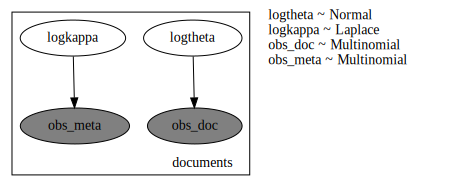

In [175]:
pyro.clear_param_store()
prod_slda.train()
_

In [176]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [177]:
print(pyro.poutine.trace(prod_slda.model).get_trace(test_['bow'].to(DEVICE), test_['meta'].to(DEVICE)).format_shapes())

              Trace Shapes:             
               Param Sites:             
      decoder$$$beta.weight 9222 20     
style_decoder$$$beta.weight   12 20     
              Sample Sites:             
             documents dist       |     
                      value  512  |     
              logtheta dist  512  |   20
                      value  512  |   20
              logkappa dist  512  |   20
                      value  512  |   20
               obs_doc dist  512  | 9222
                      value  512  | 9222
              obs_meta dist  512  |   12
                      value  512  |   12


In [178]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), test_['meta'].to(DEVICE)).format_shapes())


              Trace Shapes:            
               Param Sites:            
       encoder$$$fc1.weight  64 9222   
         encoder$$$fc1.bias       64   
       encoder$$$fc2.weight  64   64   
         encoder$$$fc2.bias       64   
      encoder$$$fcmu.weight  20   64   
        encoder$$$fcmu.bias       20   
      encoder$$$fclv.weight  20   64   
        encoder$$$fclv.bias       20   
 style_encoder$$$fc1.weight  64 9222   
   style_encoder$$$fc1.bias       64   
 style_encoder$$$fc2.weight  64   64   
   style_encoder$$$fc2.bias       64   
style_encoder$$$fcmu.weight  20   64   
  style_encoder$$$fcmu.bias       20   
style_encoder$$$fclv.weight  20   64   
  style_encoder$$$fclv.bias       20   
              Sample Sites:            
             documents dist        |   
                      value 512    |   
              logtheta dist 512    | 20
                      value 512    | 20
              logkappa dist 512    | 20
                      value 512    | 20


In [179]:
train_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    for i, batch in enumerate(dl):
        
        bow = batch['bow'].to(DEVICE)
        bop = batch['meta'].to(DEVICE)
        
        epoch_elbo += svi.step(bow, bop)
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)

---TRAINING---


/home/ndeas/envs/test_env/lib/python3.8/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs_meta', 'obs_doc'}
  warnings.warn(


Epoch 0: 35429.980
Epoch 1: 35044.375
Epoch 2: 34694.578
Epoch 3: 34381.309
Epoch 4: 34164.132
Epoch 5: 34040.122
Epoch 6: 34010.540
Epoch 7: 33985.624
Epoch 8: 33959.979
Epoch 9: 33957.539
Epoch 10: 33956.995
Epoch 11: 33949.561
Epoch 12: 33943.447
Epoch 13: 33944.722
Epoch 14: 33938.450
Epoch 15: 33940.313
Epoch 16: 33935.557
Epoch 17: 33933.815
Epoch 18: 33928.471
Epoch 19: 33930.410
Epoch 20: 33930.759
Epoch 21: 33936.281
Epoch 22: 33925.130
Epoch 23: 33923.342
Epoch 24: 33923.810
Epoch 25: 33921.978
Epoch 26: 33923.227
Epoch 27: 33917.850


KeyboardInterrupt: 

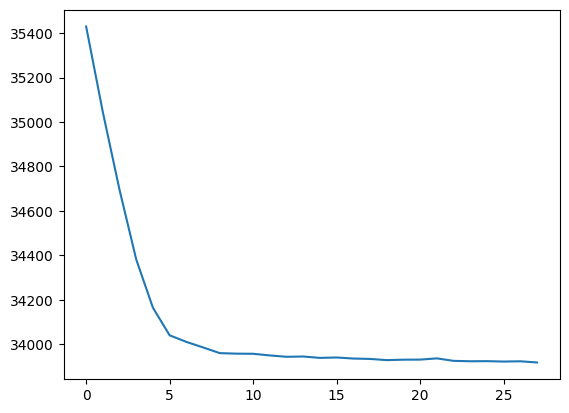

In [181]:
plt.plot(range(len(train_elbo)), train_elbo)

plt.show()